<a href="https://colab.research.google.com/github/spiritofdragon/lung_tumor_segmentation/blob/main/Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from pathlib import Path
import numpy as np
import torch
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import imgaug
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa


In [13]:
class LungDataset(torch.utils.data.Dataset):
  def __init__(self, root, augment_params):
    self.all_files = self.extract_files(root)
    self.augment_params = augment_params

  def extract_files(self, root):
    files = []
    for subject in root.glob("*"):
      slice_path = subject/"data"
      for slice in slice_path.glob("*.npy"):
        files.append(slice)
    return files

  def change_image_to_label_path(self, path):
    parts = list(path.parts)
    parts[parts.index("data")] = "masks"
    return Path(*parts)

  def augment(self, slice, mask):
    random_seed = torch.randint(0, 1000000, (1,))[0].item()
    imgaug.seed(random_seed)
    mask = mask.astype(bool)
    mask = SegmentationMapsOnImage(mask, mask.shape)
    slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps = mask)
    mask_aug = mask_aug.get_arr().astype(np.int32)
    return slice_aug, mask_aug

  def __len__(self):
    return len(self.all_files)

  def __getitem__(self, idx):
    file_path = self.all_files[idx]
    mask_path = self.change_image_to_label_path(file_path)
    slice = np.load(file_path).astype(np.float32)
    mask = np.load(mask_path)

    if self.augment_params:
      slice, mask = self.augment(slice, mask)

    return np.expand_dims(slice, 0), np.expand_dims(mask, 0)


In [14]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15), rotate=(-45, 45)),
    iaa.ElasticTransformation()
])

In [15]:
path = Path("/content/drive/MyDrive/07-Lung-Tumor/Preprocessed/train/")
dataset = LungDataset(path, seq)

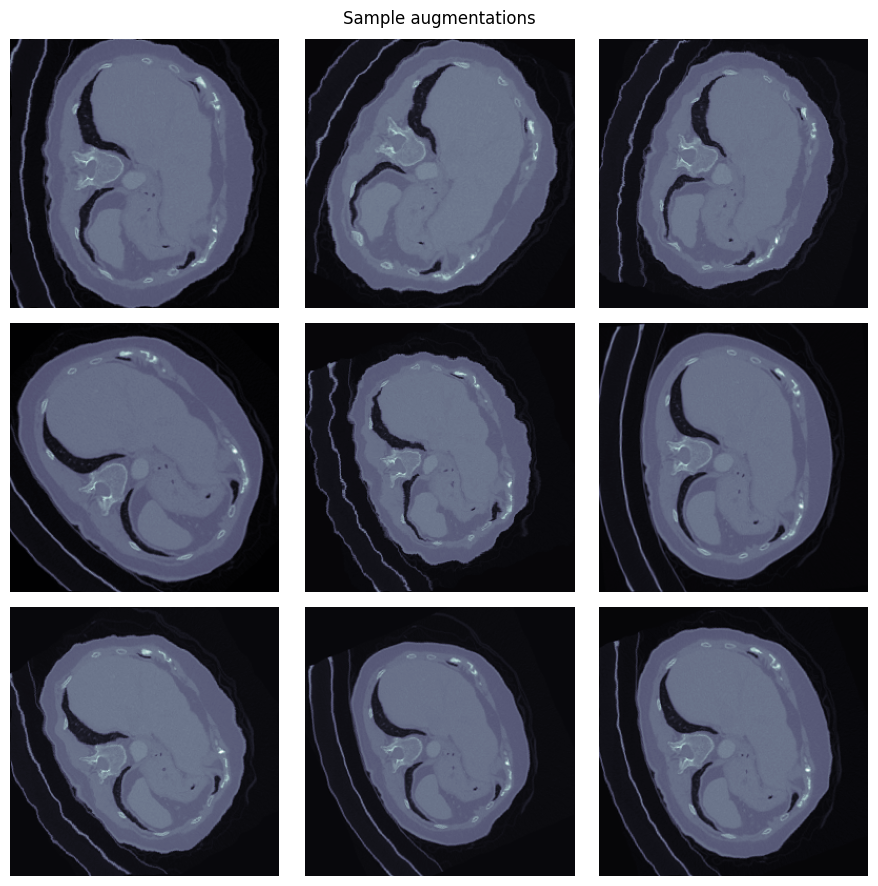

In [16]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
  for j in range(3):
    slice, mask = dataset[19]
    mask_ = np.ma.masked_where(mask==0, mask)
    axis[i][j].imshow(slice[0], cmap="bone")
    axis[i][j].imshow(mask_[0], cmap="autumn")
    axis[i][j].axis("off")

fig.suptitle("Sample augmentations")
plt.tight_layout()